In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import scale, LabelEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

# Importing DataFrame

In [2]:
df  = pd.read_pickle('waferImg26x26.pkl')
images = df.images.values
labels   = df.labels.values
labels = np.asarray([str(l[0]) for l in labels])

In [3]:
X = []
for image in images:
    X.append(np.moveaxis(image, 0, 2))
X = np.array(X).astype('float32')

print('some example of labels : ', labels[890:900])
print('Current shape of X : ', X.shape)

some example of labels :  ['none' 'none' 'none' 'none' 'none' 'none' 'Random' 'none' 'none' 'none']
Current shape of X :  (14366, 26, 26, 3)


In [4]:
labels_table, labels_counts = np.unique(labels, return_counts=True)

print('Label - Occurences')
print('__________________')
for label, count in zip(labels_table, labels_counts):
    print('%s : %d'%(label, count))

Label - Occurences
__________________
Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


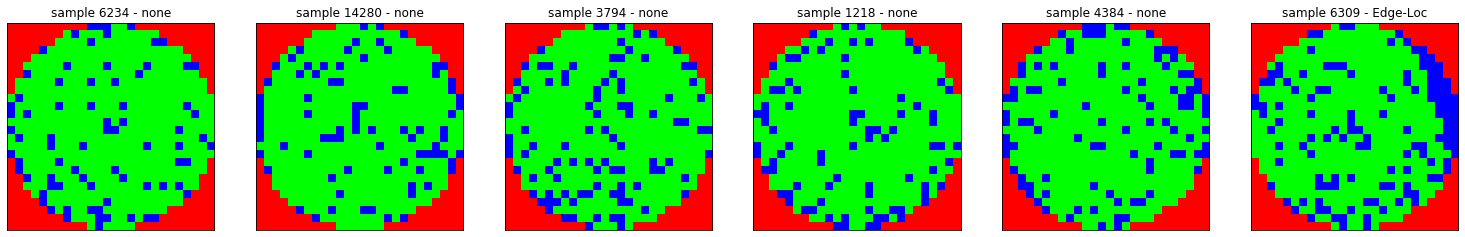

In [25]:
n_items = 6
plt.figure(figsize = (26, 26))
for i in range(n_items):
    j = np.random.choice(len(labels))
    graph = plt.subplot(2, n_items, i+1)
    plt.imshow(X[j,:])
    plt.title('sample %d - %s'%(j, labels[j]))
    plt.gray()
    graph.get_xaxis().set_visible(False)
    graph.get_yaxis().set_visible(False)

plt.show()

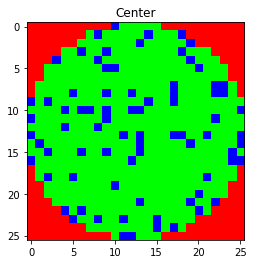

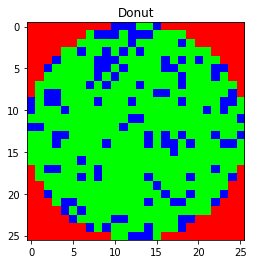

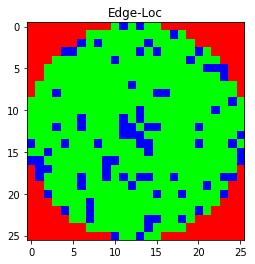

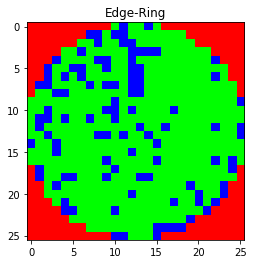

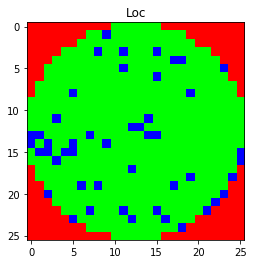

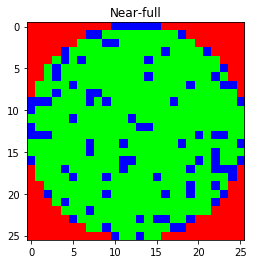

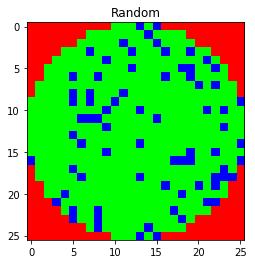

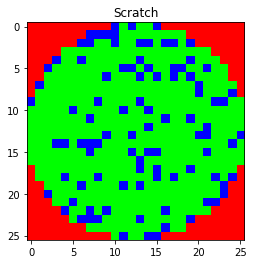

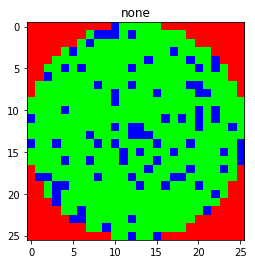

In [55]:
for label in labels_table:
    ids = np.where(labels == label)[0]
    j = np.random.choice(np.size(ids))
    plt.imshow(X[ids[j],:])
    plt.title(label)
    plt.show()

## Data Preprocessing.
### 1. transform labels to categorical for better learning

In [26]:
le = LabelEncoder()
Y = le.fit_transform(labels)
Y = tf.keras.utils.to_categorical(Y, num_classes = len(labels_table))

### 2. Splitting the dataset into train, test and validate.

In [27]:
p_train = 0.8
p_val = 0.1

n_train = round(len(labels)*p_train)
n_val = round(len(labels)*p_val)
n_test = len(labels) - n_train - n_val

n_classes = len(labels_table)

print('Dataset splitting proportions : ')
print('train = ', n_train)
print('validate = ', n_val)
print('test = ', n_test)
print('total = ', len(labels))

Dataset splitting proportions : 
train =  11493
validate =  1437
test =  1436
total =  14366


In [28]:
X, Y = shuffle(X, Y)

x_train = X[:n_train]
y_train = Y[:n_train]

x_val = X[n_train:n_train + n_val]
y_val = Y[n_train:n_train + n_val]

x_test = X[n_train + n_val:]
y_test = Y[n_train + n_val:]

In [29]:
print('x_test shape : ', np.shape(x_test))
print('y_test shape : ', np.shape(y_test))

x_test shape :  (1436, 26, 26, 3)
y_test shape :  (1436, 9)


# Defining the model

In [34]:
batch_size = 32
epochs = 40
weight_decay = 1e-4

In [35]:
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape = (26, 26, 3)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(n_classes, activation = 'softmax'))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)       

In [38]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.Recall(top_k = 1), tf.keras.metrics.Precision(top_k = 1)
])

## Training

Added a tensorboard callback to be able to see the evolution of the relevant metrics during the training phase.

In [39]:
model_name = 'wafer'
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = '.\\logs\\%s'%model_name)

model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), callbacks = [tensorboard])

Train on 11493 samples, validate on 1437 samples
Epoch 1/40
11493/11493 [==============================] - 39s 3ms/sample - loss: 0.3899 - accuracy: 0.9387 - recall_1: 0.9387 - precision_1: 0.9387 - val_loss: 0.2820 - val_accuracy: 0.9499 - val_recall_1: 0.9499 - val_precision_1: 0.9499
Epoch 2/40
11493/11493 [==============================] - 35s 3ms/sample - loss: 0.2138 - accuracy: 0.9607 - recall_1: 0.9607 - precision_1: 0.9607 - val_loss: 0.1798 - val_accuracy: 0.9666 - val_recall_1: 0.9666 - val_precision_1: 0.9666
Epoch 3/40
11493/11493 [==============================] - 36s 3ms/sample - loss: 0.1831 - accuracy: 0.9638 - recall_1: 0.9638 - precision_1: 0.9638 - val_loss: 0.2287 - val_accuracy: 0.9638 - val_recall_1: 0.9638 - val_precision_1: 0.9638
Epoch 4/40
11493/11493 [==============================] - 35s 3ms/sample - loss: 0.1637 - accuracy: 0.9675 - recall_1: 0.9675 - precision_1: 0.9675 - val_loss: 0.1571 - val_accuracy: 0.9722 - val_recall_1: 0.9722 - val_precision_1: 0.

11493/11493 [==============================] - 36s 3ms/sample - loss: 0.1090 - accuracy: 0.9910 - recall_1: 0.9910 - precision_1: 0.9910 - val_loss: 0.2140 - val_accuracy: 0.9722 - val_recall_1: 0.9722 - val_precision_1: 0.9722
Epoch 35/40
11493/11493 [==============================] - 32s 3ms/sample - loss: 0.1058 - accuracy: 0.9921 - recall_1: 0.9921 - precision_1: 0.9921 - val_loss: 0.2154 - val_accuracy: 0.9715 - val_recall_1: 0.9715 - val_precision_1: 0.9715
Epoch 36/40
11493/11493 [==============================] - 32s 3ms/sample - loss: 0.1083 - accuracy: 0.9910 - recall_1: 0.9910 - precision_1: 0.9910 - val_loss: 0.3066 - val_accuracy: 0.9715 - val_recall_1: 0.9715 - val_precision_1: 0.9715
Epoch 37/40
11493/11493 [==============================] - 33s 3ms/sample - loss: 0.1135 - accuracy: 0.9905 - recall_1: 0.9905 - precision_1: 0.9905 - val_loss: 0.2824 - val_accuracy: 0.9687 - val_recall_1: 0.9687 - val_precision_1: 0.9687
Epoch 38/40
11493/11493 [===========================

In [56]:
loss, acc, recall, precision = model.evaluate(x_test, y_test)
print('Achieved %.4f loss on test set with an accuracy of %.4f'%(loss, acc) + ' %.')
print('recall = %f, precision = %f'%(recall, precision))

1436/1436 [==============================] - 2s 1ms/sample - loss: 0.3143 - accuracy: 0.9721 - recall_1: 0.9721 - precision_1: 0.9721
Achieved 0.3143 loss on test set with an accuracy of 0.9721 %.
recall = 0.972145, precision = 0.972145


In [57]:
n = 100

predictions = model(x_test[:n, :])

for i in range(n):
    pred = labels_table[np.argmax(predictions[i])]
    actual = labels_table[np.argmax(y_test[i])]
    print('prediction is %s'%pred)
    print('real value is %s'%actual)
    print('__________________________')

prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real value is none
__________________________
prediction is none
real v

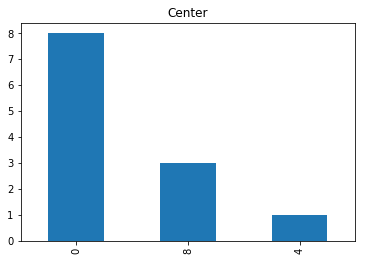

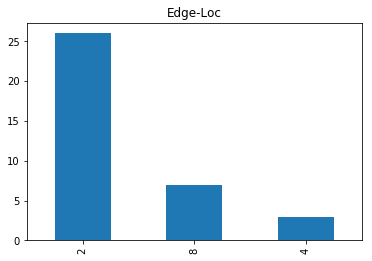

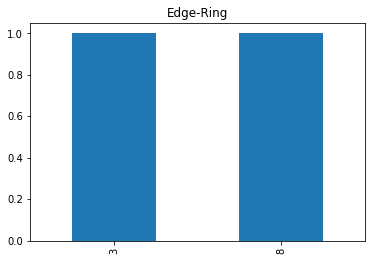

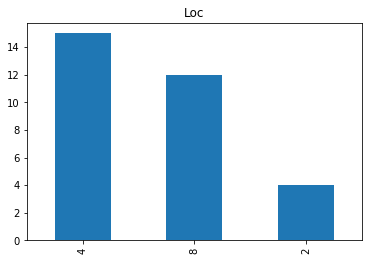

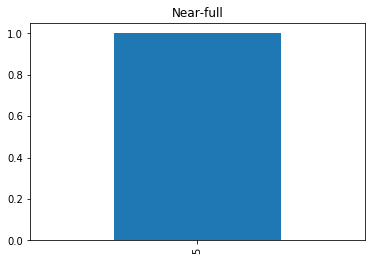

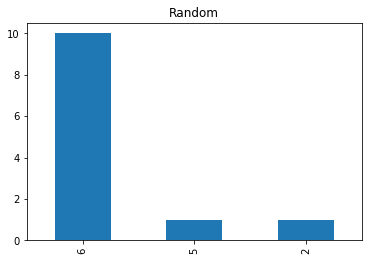

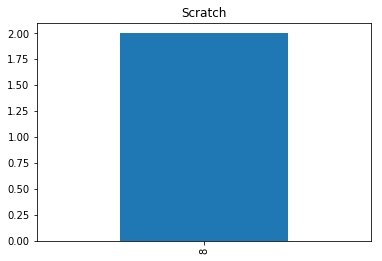

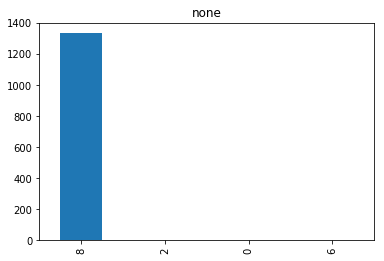

In [69]:
predictions = model(x_test)
predictions = np.argmax(predictions, axis = 1)

y_n = np.argmax(y_test, axis = 1)

for num, label in enumerate(labels_table):
    ids = np.where(y_n == num)
    if len(ids[0]) > 0:
        pd.Series(predictions[ids]).value_counts().plot('bar')
        plt.title(label)
        plt.show()

The results obtained seem to be satisfying but we cannot be sure because the data is very unbalanced and the nature of the data makes it difficult to correctly implement data augmentation.
In order to have a more robust and reliable model, it's necessary to improve the dataset by labeling more elements in each category.

# Using PCA and Kmeans

## Dimensionnality reduction using PCA.

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA(n_components = 256)

In [31]:
def preprocess(X):
    XX = np.zeros((len(Y), 26*26*3))
    for i in range(len(X)):
        XX[i,:]=X[i].flatten()
    return XX

XX = preprocess(X)
XX.shape

(14366, 2028)

In [32]:
pca.fit(XX)

PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [33]:
XX = pca.transform(XX)

In [34]:
XX.shape

(14366, 256)

Calculate the centroids of the labeled elements in order to use them for initialisation.

In [35]:
centroids_init = []

for label in labels_table[:-1]:
    ids = np.where(labels == label)
    centroid = np.mean(XX[ids], axis = 0)
    centroids_init.append(centroid)

centroids_init = np.array(centroids_init).astype('float32')

print('Initial centroids array has shape : %s'%repr(np.shape(centroids_init)))

Initial centroids array has shape : (8, 256)


## Implementing Kmeans to cluster the elements.

In [36]:
from sklearn.cluster import KMeans

In [37]:
kmeans = KMeans(n_clusters = 8, init=centroids_init)

In [38]:
kmeans.fit(XX)

KMeans(algorithm='auto', copy_x=True,
       init=array([[ 0.07484809,  0.11932011, -0.03681908, ...,  0.0430605 ,
         0.07335864,  0.05311121],
       [ 0.7004359 , -1.8858956 ,  0.496331  , ...,  0.00437893,
         0.3374463 , -0.36536354],
       [-0.03523334,  0.11627283, -0.03958996, ...,  0.00279919,
         0.0159864 ,  0.02427399],
       ...,
       [ 0.5276079 , -0.04481627, -0.14278871, ...,  0.15226355,
         0.11319208, -0.03386581],
       [ 0.22777748,  0.10527626, -0.03898222, ..., -0.08357485,
        -0.04805808, -0.06379446],
       [-0.06731869, -0.04502422, -0.08894829, ...,  0.07584632,
         0.09502953, -0.07913028]], dtype=float32),
       max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [39]:
clusters = kmeans.cluster_centers_
print(clusters.shape)

(8, 256)


In [40]:
y_km = kmeans.fit_predict(XX)

In [41]:
y_km.shape

(14366,)

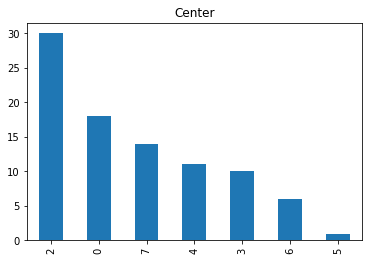

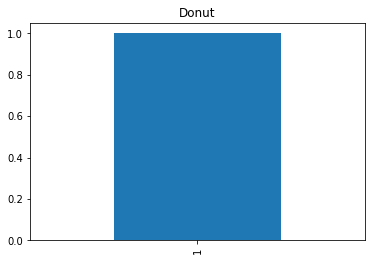

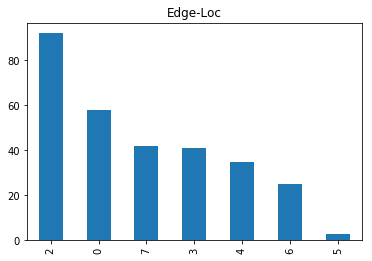

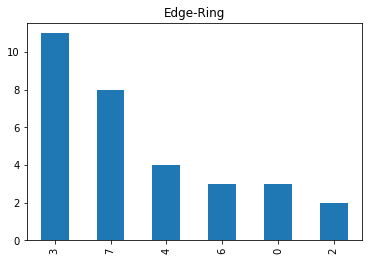

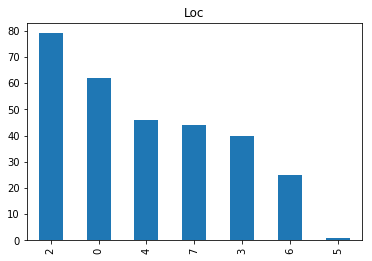

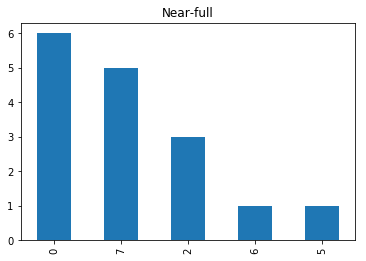

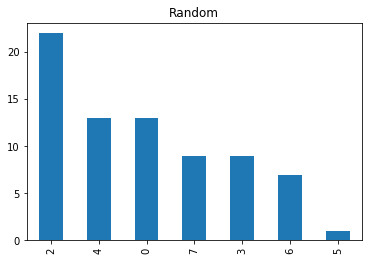

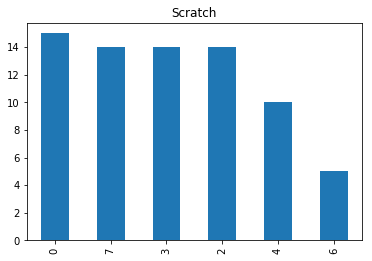

In [42]:
for label in labels_table[:-1]:
    ids = np.where(labels == label)
    pd.Series(y_km[ids]).value_counts().plot('bar')
    plt.title(label)
    plt.show()

# Conclusions

Results obtained using PCA and kmeans are unreliable.
Even without any dimensionality reduction and with proper initialization, there appears to be no structure learned in the model, different classes are present at an almost uniform rate with the class 6 being predominant in most cases.